## Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt


##  synthetic data

In [32]:
rng = np.random.default_rng(42)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def make_logreg_data(n=800, d=2, sep=1.5, bias=0.0):
    """
    n:   number of samples
    d:   number of features
    sep: controls separability (scale of true weights). Larger -> easier.
    bias: ground-truth bias (b*)
    """
    X = rng.normal(loc=0.0, scale=1.0, size=(n, d))

    # ground-truth parameters
    w_true = rng.normal(size=d)
    w_true = sep * w_true / (np.linalg.norm(w_true) + 1e-12)   # normalize then scale
    b_true = float(bias)

    logits = X @ w_true + b_true
    p = sigmoid(logits)
    y = (rng.random(n) < p).astype(int)
    return X, y, w_true, b_true

# example: easy-ish 2D dataset
X, y, w_star, b_star = make_logreg_data(n=1000, d=2, sep=2.0, bias=0.2)

# simple train/val split
idx = rng.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, val_idx = idx[:train_size], idx[train_size:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

X_train.shape, y_train.mean(), (w_star, b_star)


((800, 2), np.float64(0.545), (array([-1.12318217, -1.65482985]), 0.2))

##  Demonstration: Why the Stable Sigmoid Matters

---

### Goal

Visualize how the **unstable sigmoid** (standard formula) breaks
for large values of \( z \), and how the **stable sigmoid** fixes it.

---

### Recall the Two Forms

### Unstable (Standard):
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

### Stable (Piecewise):
$$
\sigma(z) =
\begin{cases}
\dfrac{1}{1 + e^{-z}}, & z \ge 0 \\[6pt]
\dfrac{e^{z}}{1 + e^{z}}, & z < 0
\end{cases}
$$


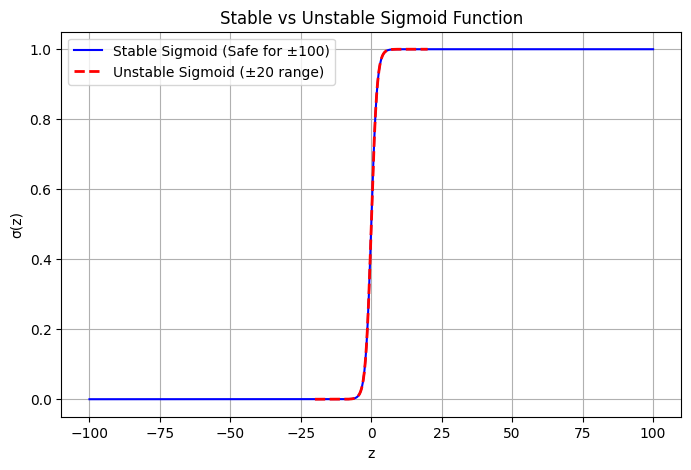

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Unstable sigmoid (normal formula)
def sigmoid_unstable(z):
    return 1 / (1 + np.exp(-z))

# Stable sigmoid (piecewise safe)
def sigmoid_stable(z):
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

# Create z ranges
z_stable = np.linspace(-100, 100, 1000)   # covers full range safely
z_unstable = np.linspace(-20, 20, 400)    # only where it won't overflow

# Compute both
sig_stable = sigmoid_stable(z_stable)
sig_unstable = sigmoid_unstable(z_unstable)

# Plot
plt.figure(figsize=(8,5))
plt.plot(z_stable, sig_stable, color='blue', label='Stable Sigmoid (Safe for ±100)')
plt.plot(z_unstable, sig_unstable, 'r--', linewidth=2, label='Unstable Sigmoid (±20 range)')
plt.title("Stable vs Unstable Sigmoid Function")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.legend()
plt.grid(True)
plt.show()



Both are mathematically identical — but behave differently numerically.

**Conclusion:**  
Using the *stable sigmoid* ensures our logistic regression stays numerically safe for any input range —  
that’s why modern ML implementations (like PyTorch, TensorFlow, NumPy) internally use this piecewise stable form.

##Sigmoid Function (σ) — Stable Mathematical Explanation

---

###  Definition

The **sigmoid (logistic)** function converts any real number \( z \) into a probability range (0, 1):

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

It maps the linear model output \( z = w^\top x + b \)
into a probability that \( y = 1 \).

---

###  Numerical Stability Problem

- When \( z \) is **very large positive** → \( e^{-z} \approx 0 \) → safe   
- When \( z \) is **very large negative** → \( e^{-z} = e^{|z|} \) → huge number  → overflow.

Example:

$$
e^{1000} \approx 10^{434} \quad \text{→ overflow in floating-point.}
$$

To fix this, we use a **piecewise formula** that handles both cases safely.

---

### Stable Piecewise Formula

$$
\sigma(z) =
\begin{cases}
\dfrac{1}{1 + e^{-z}}, & z \ge 0 \\[8pt]
\dfrac{e^{z}}{1 + e^{z}}, & z < 0
\end{cases}
$$

Both forms are mathematically identical:

$$
\frac{1}{1 + e^{-z}} = \frac{e^{z}}{1 + e^{z}}
$$

but the second version avoids computing \( e^{-z} \) for large negative \( z \).

---

### Corresponding Code


In [34]:
def sigmoid_stable(z):

  z = np.asarray(z,dtype=float)
  out = np.empty_like(z)

  pos = z>=0
  neg = ~pos

  # now to handle overflow state like if the +ve number is very large and same goes for -ve number we need to handle that one to
  out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
  ez = np.exp(z[neg])
  out[neg] = ez / (1.0 + ez)
  return out



In [35]:
def logits(X, w, b):
    """Linear score z = X @ w + b"""
    return X @ w + b

##  Binary Cross-Entropy (Log Loss)

##  For a Single Sample

The loss for one training example with label \( y \in \{0,1\} \)
and predicted probability \( \hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}} \) is:

$$
L(y, \hat{p}) = -\Big[\, y \log(\hat{p}) + (1 - y) \log(1 - \hat{p}) \,\Big]
$$

---

### For the Entire Dataset of \( n \) Samples

Averaging the loss over all samples gives:

$$
J(w, b) = -\frac{1}{n} \sum_{i=1}^{n}
\Big[\, y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \,\Big]
$$

where

$$
\hat{p}_i = \sigma(w^\top x_i + b) = \frac{1}{1 + e^{-(w^\top x_i + b)}}
$$

---

### Alternative (Numerically Stable) Form Using Softplus

To avoid overflow from \( e^{-z} \), we can rewrite it as:

$$
J(w, b) = \frac{1}{n} \sum_{i=1}^{n}
\Big[\, \log(1 + e^{z_i}) - y_i z_i \,\Big]
$$


In [36]:
def softplus(z):
  z = np.asarray(z, dtype=float)
  return np.maximum(0.0,z)+np.log1p(np.exp(-np.abs(z)))

## Compute mean binary cross-entropy loss and its gradients.

In [37]:
def bce_loss_and_grad(w, b, X, y, l2=0.0):
    """
    Mean binary cross-entropy (log loss) and gradients for logistic regression.
    Stable loss: J = mean(softplus(z) - y*z), where z = Xw + b.
    """
    z = logits(X, w, b)
    p = sigmoid_stable(z)
    n = len(X)

    # loss
    loss = np.mean(softplus(z) - y * z)
    if l2 > 0.0:
        loss += (l2 / (2.0 * n)) * np.dot(w, w)

    # gradients (THIS is the key line)
    err = (p - y) / n
    grad_w = X.T @ err
    grad_b = np.sum(err)

    if l2 > 0.0:
        grad_w += (l2 / n) * w

    return loss, grad_w, grad_b





In [38]:
def fit_logreg_gd(X, y, lr=0.01, epochs=200, l2=0.0, w0=None, b0=0.0, verbose=True):
    """
    Simple full-batch gradient descent (no validation), with:
      - gradient clipping
      - step shrink if loss increases
    """
    n, d = X.shape
    w = np.zeros(d, dtype=float) if w0 is None else np.asarray(w0, float).copy()
    b = float(b0)

    history = {"train_loss": []}
    prev_loss = float("inf")

    for epoch in range(epochs):
        loss, gw, gb = bce_loss_and_grad(w, b, X, y, l2=l2)

        # gradient clipping
        gnorm = float(np.sqrt(np.sum(gw*gw) + gb*gb))
        if gnorm > 10.0:
            scale = 10.0 / (gnorm + 1e-12)
            gw *= scale; gb *= scale

        # backoff step if loss increased
        step = lr
        if np.isfinite(prev_loss) and loss > prev_loss:
            step *= 0.5

        # DESCENT step (uses TRUE gradient)
        w -= step * gw
        b -= step * gb
        prev_loss = loss

        history["train_loss"].append(loss)
        if verbose and (epoch < 3 or (epoch + 1) % max(1, epochs // 10) == 0):
            print(f"epoch {epoch+1:4d} | loss={loss:.6f} | step={step:.5g} | ||g||={gnorm:.4f}")

    return w, b, history



## Fit and Test The Model

In [44]:
w_learned, b_learned, hist = fit_logreg_gd(
    X_train, y_train,
    lr=0.01,
    epochs=500,
    l2=0.0,
    verbose=True
)


epoch    1 | loss=0.693147 | step=0.01 | ||g||=0.3085
epoch    2 | loss=0.692197 | step=0.01 | ||g||=0.3077
epoch    3 | loss=0.691251 | step=0.01 | ||g||=0.3069
epoch   50 | loss=0.652065 | step=0.01 | ||g||=0.2707
epoch  100 | loss=0.619762 | step=0.01 | ||g||=0.2379
epoch  150 | loss=0.594664 | step=0.01 | ||g||=0.2104
epoch  200 | loss=0.574890 | step=0.01 | ||g||=0.1875
epoch  250 | loss=0.559080 | step=0.01 | ||g||=0.1683
epoch  300 | loss=0.546263 | step=0.01 | ||g||=0.1521
epoch  350 | loss=0.535738 | step=0.01 | ||g||=0.1382
epoch  400 | loss=0.526996 | step=0.01 | ||g||=0.1263
epoch  450 | loss=0.519661 | step=0.01 | ||g||=0.1160
epoch  500 | loss=0.513449 | step=0.01 | ||g||=0.1070


## Helpers To See

In [45]:
def predict_proba(X, w, b):
    """Return P(y=1|x) for each row in X."""
    return sigmoid_stable(logits(X, w, b))

def predict(X, w, b, threshold=0.5):
    """Return class labels {0,1} using a threshold on probability."""
    return (predict_proba(X, w, b) >= threshold).astype(int)

def accuracy(X, y, w, b, threshold=0.5):
    """Simple accuracy metric."""
    y_hat = predict(X, w, b, threshold)
    return (y_hat == y).mean()


## Train Accuracy

In [46]:
w_learned, b_learned, hist = fit_logreg_gd(X_train, y_train, lr=0.01, epochs=300, l2=0.0, verbose=True)
print("final train loss:", hist["train_loss"][-1])
print("train accuracy:", accuracy(X_train, y_train, w_learned, b_learned))

epoch    1 | loss=0.693147 | step=0.01 | ||g||=0.3085
epoch    2 | loss=0.692197 | step=0.01 | ||g||=0.3077
epoch    3 | loss=0.691251 | step=0.01 | ||g||=0.3069
epoch   30 | loss=0.667547 | step=0.01 | ||g||=0.2855
epoch   60 | loss=0.644916 | step=0.01 | ||g||=0.2637
epoch   90 | loss=0.625575 | step=0.01 | ||g||=0.2440
epoch  120 | loss=0.608977 | step=0.01 | ||g||=0.2263
epoch  150 | loss=0.594664 | step=0.01 | ||g||=0.2104
epoch  180 | loss=0.582258 | step=0.01 | ||g||=0.1962
epoch  210 | loss=0.571446 | step=0.01 | ||g||=0.1834
epoch  240 | loss=0.561976 | step=0.01 | ||g||=0.1719
epoch  270 | loss=0.553639 | step=0.01 | ||g||=0.1615
epoch  300 | loss=0.546263 | step=0.01 | ||g||=0.1521
final train loss: 0.5462631035928165
train accuracy: 0.78625


## Confusion matrix

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

# 1) Probabilities and default 0.5 threshold
proba = predict_proba(X_train, w_learned, b_learned)
y_hat = (proba >= 0.5).astype(int)

cm = confusion_matrix(y_train, y_hat)
prec, rec, f1, _ = precision_recall_fscore_support(y_train, y_hat, average='binary')
auc = roc_auc_score(y_train, proba)

print("Confusion matrix:\n", cm)
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

Confusion matrix:
 [[272  92]
 [ 79 357]]
Precision: 0.795 | Recall: 0.819 | F1: 0.807 | ROC-AUC: 0.858


you can add next

 1 decision boundary (2D),

2 mini-batch SGD (faster),

3 L2 regularization,